# 1 Scraping the delay data of 2015

<h3>1.1 Merge the monthly data</h3>

After downloading the data from the RITA, we found that the data are store monthly, so we need to unzip them and merge them together and extract useful information for later analysis. Specifically, each month dataset contain more than 400,000 flight records.

In [1]:
import requests, zipfile
from io import StringIO
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import re
import json
import os

In [2]:
# reads all predefined months for a year and merge into one data frame
rawData = pd.DataFrame()
months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
for m in months:
    z = zipfile.ZipFile('On_Time_On_Time_Performance_{y}_{mo}.zip'.format(y=str(2015), mo = m))
    rawData = rawData.append(pd.read_csv(z.open(z.namelist()[0])))
    print ("Downloaded", m)
# reset index of complete dataset for delays to prepare merging in next step
rawData.reset_index(inplace=True)

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (77,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Downloaded 1


/Applications/Anaconda/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Downloaded 2


/Applications/Anaconda/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (48,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Downloaded 3
Downloaded 4
Downloaded 5
Downloaded 6
Downloaded 7
Downloaded 8
Downloaded 9
Downloaded 10


/Applications/Anaconda/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (48,69,76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Downloaded 11


/Applications/Anaconda/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (48,76,77,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Downloaded 12


In [19]:
print(rawData.columns)

Index(['index', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'FlightDate', 'UniqueCarrier', 'AirlineID', 'Carrier',
       ...
       'Div4TailNum', 'Div5Airport', 'Div5AirportID', 'Div5AirportSeqID',
       'Div5WheelsOn', 'Div5TotalGTime', 'Div5LongestGTime', 'Div5WheelsOff',
       'Div5TailNum', 'Unnamed: 109'],
      dtype='object', length=111)


<h3>1.2 Extracting useful information</h3>

In [3]:
selectedColumns = [u'index', u'FlightDate', u'UniqueCarrier', u'TailNum', u'FlightNum', 
                   u'Origin', u'Dest', u'CRSDepTime', u'DepTime', u'DepDelay', u'TaxiOut', 
                   u'WheelsOff', u'WheelsOn', u'TaxiIn', u'CRSArrTime', u'ArrTime', u'ArrDelay', 
                   u'Cancelled', u'Diverted', u'CancellationCode', u'AirTime', u'Distance', 
                   u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay', u'LateAircraftDelay',
                   u'OriginCityName', u'DestCityName']
rawData = rawData[selectedColumns]

In [4]:
rawData.columns

Index(['index', 'FlightDate', 'UniqueCarrier', 'TailNum', 'FlightNum',
       'Origin', 'Dest', 'CRSDepTime', 'DepTime', 'DepDelay', 'TaxiOut',
       'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay',
       'Cancelled', 'Diverted', 'CancellationCode', 'AirTime', 'Distance',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'OriginCityName', 'DestCityName'],
      dtype='object')

In [5]:
rawData.columns = [u'index', u'FL_DATE', u'UNIQUE_CARRIER', u'TAIL_NUM', u'FL_NUM', 
                   u'ORIGIN', u'DEST', u'CRS_DEP_TIME', u'DEP_TIME', u'DEP_DELAY', u'TAXI_OUT', 
                   u'WHEELS_OFF', u'WHEELS_ON', u'TAXI_IN', u'CRS_ARR_TIME', u'ARR_TIME', u'ARR_DELAY', 
                   u'CANCELLED', u'DIVERTED', u'CANCELLATION_CODE', u'AIR_TIME', u'DISTANCE', 
                   u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY', u'SECURITY_DELAY', u'LATE_AIRCRAFT_DELAY',
                   u'ORIGIN_CITY_NAME', u'DEST_CITY_NAME']

<h3>1.3 Adding extra aircraft information</h3>

Sometimes the manufacture year or aircraft manufacturer will influence the on-time performance of flight, since some older aircrafts are more likely to have machanical issues than other newly produced airplance, and some aircrtaft produced by some specific manufacture companies are more likely to have potential problems caused flight delay.

In [22]:
z = zipfile.ZipFile('AircraftInformation.zip')
# master table containing tail numbers of aircraft
df_master  = pd.DataFrame.from_csv(z.open('MASTER.txt'))
# detailed table containing information about manufacturer, age, etc.
df_aircrafts  = pd.DataFrame.from_csv(z.open('ACFTREF.txt'))

In [23]:
master = df_master[['MFR MDL CODE', 'YEAR MFR']].reset_index()
aircrafts = df_aircrafts['MFR'].reset_index()
master.columns = ['TAIL_NUM', 'CODE', 'YEAR']
aircrafts.columns = ['CODE', 'MFR']
joined = pd.merge(master, aircrafts, how='left', on='CODE')

In [24]:
joined.head(5)

,TAIL_NUM,CODE,YEAR,MFR
0,1,3980115,1988,GULFSTREAM AEROSPACE
1,100,7100510,1940,PIPER
2,10001,9601202,1928,WACO
3,10002,8930105,1979,TEXAS HELICOPTER CORP
4,10003,056336T,,CHARLES N CAMPBELL


In [25]:
delayFinal = rawData[['TAIL_NUM','UNIQUE_CARRIER']]
delayFinal.columns = ['TAIL_NUM','UNIQUE_CARRIER']
delayFinal.TAIL_NUM = delayFinal.TAIL_NUM.str.strip('N')
delaymfr = pd.merge(delayFinal, joined, how='left', on=['TAIL_NUM'])
rawData['AIRCRAFT_YEAR'] = delaymfr.YEAR
rawData['AIRCRAFT_MFR'] = delaymfr.MFR

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [26]:
rawData.head(5)

,index,FL_DATE,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_CITY_NAME,DEST_CITY_NAME,AIRCRAFT_YEAR,AIRCRAFT_MFR
0,0,2015-01-01,AA,N787AA,1,JFK,LAX,900,855.0,-5.0,...,2475.0,NaN,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",NaN,NaN
1,1,2015-01-02,AA,N795AA,1,JFK,LAX,900,850.0,-10.0,...,2475.0,NaN,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",1959,BEECH
2,2,2015-01-03,AA,N788AA,1,JFK,LAX,900,853.0,-7.0,...,2475.0,NaN,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",NaN,NaN
3,3,2015-01-04,AA,N791AA,1,JFK,LAX,900,853.0,-7.0,...,2475.0,NaN,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",1979,BEECH
4,4,2015-01-05,AA,N783AA,1,JFK,LAX,900,853.0,-7.0,...,2475.0,NaN,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",NaN,NaN


<h3>1.4 Combining data with airport location information</h3>

We can approach the geometric information of airport from <a href = "http://openflights.org/data.html">openflights.org</a>. With the geo-information of airport, we can analyse the geometric flight delay trendancy, and get statistic analysis of monthly, seasonly or yearly flight delay.

In [27]:
airportLocation = pd.DataFrame.from_csv('airport_codes_with_geo_name_ids_and_nl_names-2008-04-14.csv', header=None)
usAirports = airportLocation[airportLocation[4]=='US'].reset_index()
# we just need a subsets of the columns (origin, latitude and longitude)
usAirports = usAirports[[0, 5, 6]]
usAirports.columns = ['ORIGIN', 'LAT', 'LONG']

In [28]:
complete2015Data = pd.merge(rawData, usAirports, how='left', on='ORIGIN')

In [29]:
complete2015Data.head(5)

,index,FL_DATE,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_CITY_NAME,DEST_CITY_NAME,AIRCRAFT_YEAR,AIRCRAFT_MFR,LAT,LONG
0,0,2015-01-01,AA,N787AA,1,JFK,LAX,900,855.0,-5.0,...,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",NaN,NaN,40.633333,-73.783333
1,1,2015-01-02,AA,N795AA,1,JFK,LAX,900,850.0,-10.0,...,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",1959,BEECH,40.633333,-73.783333
2,2,2015-01-03,AA,N788AA,1,JFK,LAX,900,853.0,-7.0,...,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",NaN,NaN,40.633333,-73.783333
3,3,2015-01-04,AA,N791AA,1,JFK,LAX,900,853.0,-7.0,...,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",1979,BEECH,40.633333,-73.783333
4,4,2015-01-05,AA,N783AA,1,JFK,LAX,900,853.0,-7.0,...,NaN,NaN,NaN,NaN,"New York, NY","Los Angeles, CA",NaN,NaN,40.633333,-73.783333


Just 0.7% of alll flight origins could not be located, so the merge is quite successful.

In [32]:
1.0*np.sum(complete2015Data.LAT.isnull())/complete2015Data.shape[0]

0.0071925471367548025

<h3>1.5 Storing dataframe to .csv file</h3>

For the convinence of later file input, storing dataframe to .csv file saves us a lot of time.

In [33]:
complete2015Data.to_csv('complete2015Data.csv')

<h3>1.6 Creating subset for later linear regression model</h3>

#### Pruning the data
we removed the following entries from the raw dataset:

- flights that have been cancelled or diverted. We focus on predicting the delay. As a result, we also remove the columns associated with diverted flights.
- colmuns that give the answer. This is the case of many colmuns related to the arrival of the plane
- rows where a value is missing

In [34]:
#entries to be dropped in the analysis
flight_data_dropped = ['QUARTER', 'DAY_OF_MONTH', 'AIRLINE_ID', 'CARRIER', 'FL_NUM', 'TAIL_NUM']

location_data_dropped = ['ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM',\
                    'ORIGIN_WAC', 'DEST_STATE_FIPS', \
                    'DEST_STATE_NM', 'DEST_WAC']

departure_data_dropped = ['DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',\
                          'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF']

arrival_data_dropped = ['WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY_NEW',\
                       'ARR_DELAY_GROUP', 'ARR_TIME_BLK']

cancel_data_dropped = ['CANCELLED','CANCELLATION_CODE', 'DIVERTED']

summaries_dropped = ['CRS_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS']

cause_delay_dropped = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

gate_return_dropped = ['FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME']

diverted_data_dropped = ['DIV_AIRPORT_LANDINGS', 'DIV_REACHED_DEST', 'DIV_ACTUAL_ELAPSED_TIME',  \
                         'DIV_ARR_DELAY', 'DIV_DISTANCE', 'DIV1_AIRPORT', 'DIV1_WHEELS_ON', \
                         'DIV1_TOTAL_GTIME', 'DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF', \
                         'DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_WHEELS_ON', \
                         'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF', \
                         'DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_WHEELS_ON', \
                         'DIV3_TOTAL_GTIME', 'DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF', 'DIV3_TAIL_NUM', \
                         'DIV4_AIRPORT', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_LONGEST_GTIME', \
                         'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_WHEELS_ON', \
                         'DIV5_TOTAL_GTIME', 'DIV5_LONGEST_GTIME', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM']

other_dropped = ['Unnamed: 93']

columns_dropped = flight_data_dropped + location_data_dropped + departure_data_dropped + arrival_data_dropped \
    + cancel_data_dropped + summaries_dropped + cause_delay_dropped + gate_return_dropped + diverted_data_dropped \
    + other_dropped

In [35]:
def clean(data, list_col):
    # security check to drop only columns that exist
    list_col = list(set(list_col) & set(data.columns))
    
    res = data[(data.CANCELLED == 0) & (data.DIVERTED == 0)]
    res.drop(list_col, axis=1, inplace=True)
    res.dropna(axis = 0, inplace = True)
    return res

In [36]:
%%time
data2015 = clean(complete2015Data, columns_dropped)

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 8.13 s, sys: 13.7 s, total: 21.8 s
Wall time: 38.8 s


/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
data2015.columns

Index(['index', 'FL_DATE', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'CRS_ARR_TIME', 'ARR_DELAY', 'DISTANCE', 'ORIGIN_CITY_NAME',
       'DEST_CITY_NAME', 'AIRCRAFT_YEAR', 'AIRCRAFT_MFR', 'LAT', 'LONG'],
      dtype='object')

After pruning the raw dataset, we want to extract the airline which has been shutdown, so we use the 'cur_airlines.txt' to matching the current active airlines. The 'cur_airlines.txt' contains the airline with Unique Carrier number which are active registration in the Federal Aviation Administration (FAA). With pruning the shutdown airlines, we can improve the accuracy of prediction.

In [41]:
df_active_airlines = pd.read_csv('cur_airlines.txt', header=None)
df_active_airlines.columns = [['UNIQUE_CARRIER']];
df_active_airlines.head(5)

,UNIQUE_CARRIER
0,M3
1,JP
2,A3
3,EI
4,NG


In [42]:
filteredData2015 = data2015.merge(df_active_airlines, on=['UNIQUE_CARRIER', 'UNIQUE_CARRIER'], how='inner')

In [44]:
# save data to cache
filteredData2015.to_csv('linear_model_data.csv')

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('linear_model_data.csv')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Now after the pruning, we clean the raw dataset of 2015 to <b>4140995</b> records.

In [3]:
df.count()[0]

4140995

In [5]:
df = []

# Statistic analysis

In [46]:
departureDelayed = complete2015Data.DEP_DELAY >= 15
arrivalDelayed = complete2015Data.ARR_DELAY >= 15
bothDelayed = (complete2015Data.DEP_DELAY >= 15) & (complete2015Data.ARR_DELAY >= 15)

print ("Percentage departure delays out of all flights: ", sum(departureDelayed)/float(len(complete2015Data)))
print ("Percentage arrival delays out of all flights: ", sum(arrivalDelayed)/float(len(complete2015Data)))
print ("Arrival delayed if departure was already delayed: ", sum(bothDelayed)/float(sum(arrivalDelayed)))

Percentage departure delays out of all flights:  0.181739069018
Percentage arrival delays out of all flights:  0.182750397443
Arrival delayed if departure was already delayed:  0.781180678911


In [47]:
import pandas as pd
import matplotlib
import numpy as np
matplotlib.style.use('fivethirtyeight')
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [48]:
threshold = 300 # Minimum number of flights per day

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


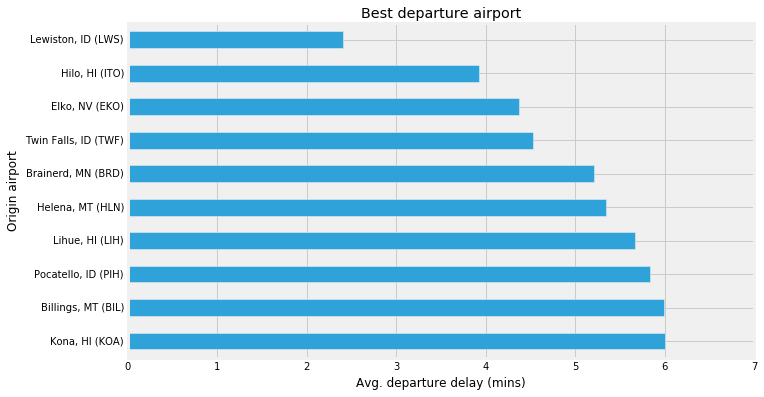

In [49]:
OADelay = complete2015Data[['ORIGIN', 'DEP_DELAY', 'ORIGIN_CITY_NAME']] 
OADelay = OADelay[OADelay.DEP_DELAY.notnull()] # Ignore entries with NaN values
OADelay.ix[(OADelay.DEP_DELAY < 0), 'DEP_DELAY'] = 0 # Don't consider early departures
OADelay['ORIGIN'] = OADelay['ORIGIN_CITY_NAME'] + ' (' + OADelay['ORIGIN'] + ')'

gbOA = OADelay.groupby('ORIGIN').agg(['mean', 'count'])
gbOA = gbOA[gbOA['DEP_DELAY']['count'] > threshold] # Select only origin airports with at least 1 flight per day

gbOA = gbOA.sort([('DEP_DELAY','mean')], ascending = True)
ax = gbOA.head(10)['DEP_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax.set_xlabel('Avg. departure delay (mins)')
ax.set_ylabel('Origin airport')
ax.set_title('Best departure airport')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


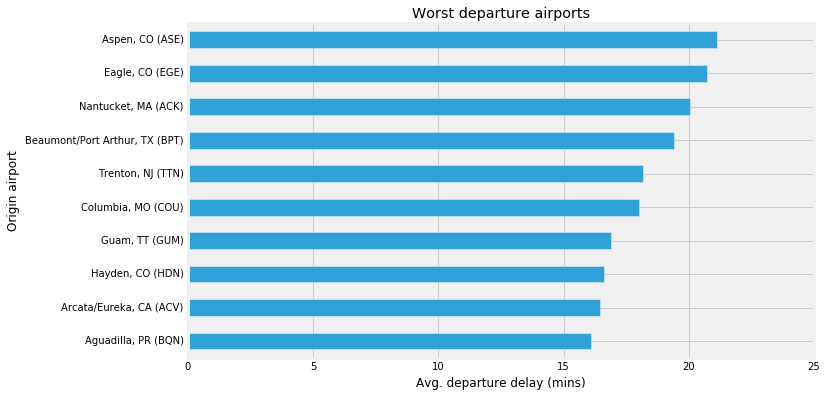

In [50]:
gbOA = gbOA.sort([('DEP_DELAY','mean')], ascending = False)
ax2 = gbOA.head(10)['DEP_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. departure delay (mins)')
ax2.set_ylabel('Origin airport')
ax2.set_title('Worst departure airports')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


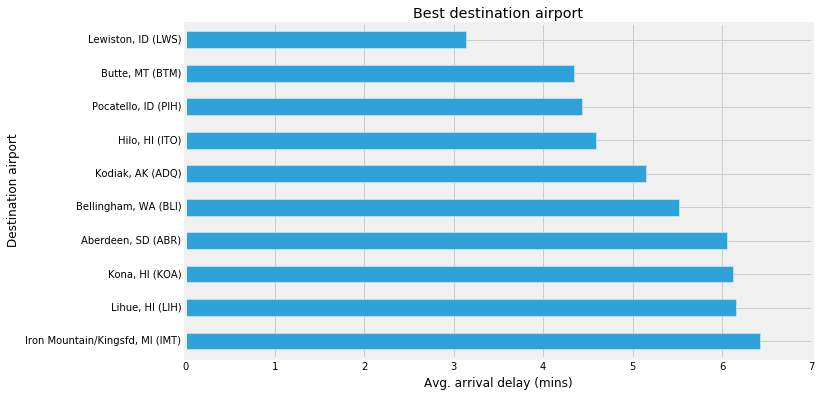

In [51]:
DADelay = complete2015Data[['DEST', 'ARR_DELAY', 'DEST_CITY_NAME']] 
DADelay = DADelay[DADelay.ARR_DELAY.notnull()] # Ignore entries with NaN values
DADelay.ix[(DADelay.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures
DADelay['DEST'] = DADelay['DEST_CITY_NAME'] + ' (' + DADelay['DEST'] + ')'

gbDA = DADelay.groupby('DEST').agg(['mean', 'count'])
gbDA = gbDA[gbDA['ARR_DELAY']['count'] > threshold] # Select only origin airports with at least 1 flight per day
gbDA = gbDA.sort([('ARR_DELAY','mean')], ascending = True)

ax = gbDA.head(10)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax.set_xlabel('Avg. arrival delay (mins)')
ax.set_ylabel('Destination airport')
ax.set_title('Best destination airport')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


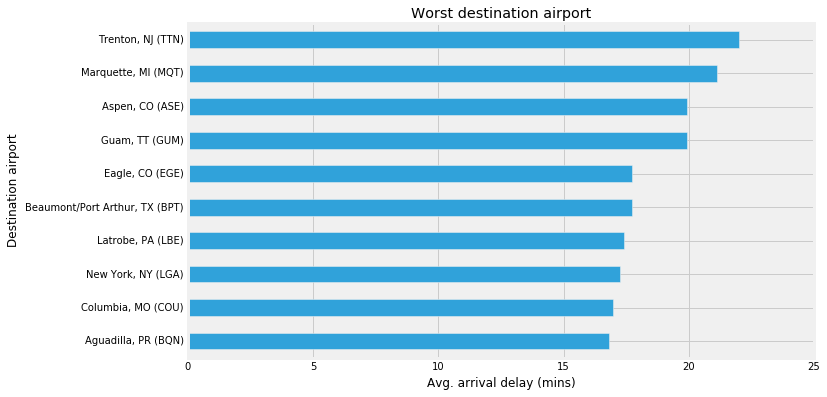

In [52]:
gbDA = gbDA.sort([('ARR_DELAY','mean')], ascending = False)
ax2 = gbDA.head(10)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Destination airport')
ax2.set_title('Worst destination airport')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


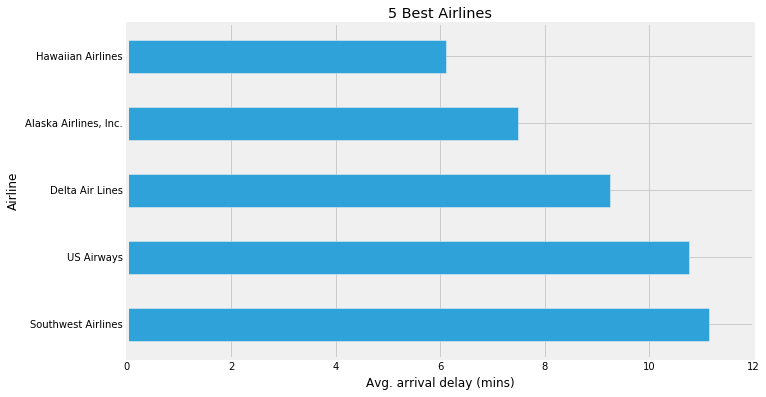

In [53]:
ANames = pd.read_csv('airline_names.csv')

AA = complete2015Data[['UNIQUE_CARRIER', 'ARR_DELAY']]
AA = pd.merge(AA, ANames, how='left', on='UNIQUE_CARRIER')
AA = AA[AA.ARR_DELAY.notnull()] # Ignore entries with NaN values
AA.ix[(AA.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures

AAgb = AA.groupby('UNIQUE_CARRIER').agg({'ARR_DELAY':['mean','count'], 'CARRIER_NAME': ['min']})
AAgb = AAgb[AAgb['ARR_DELAY']['count'] > threshold] # Select only airlines with at least 1 flight per day
AAgb = AAgb.sort([('ARR_DELAY','mean')], ascending = True)
AAgb = AAgb.set_index( ('CARRIER_NAME', 'min') )

ax2 = AAgb.head(5)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Airline')
ax2.set_title('5 Best Airlines')


/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


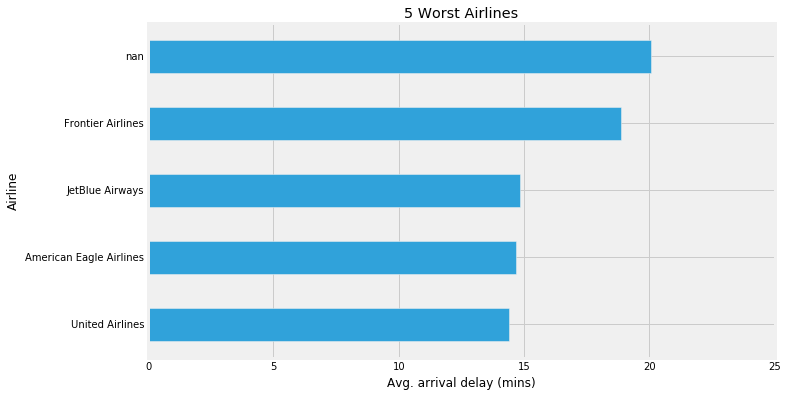

In [54]:
AAgb = AAgb.sort([('ARR_DELAY','mean')], ascending = False)
ax2 = AAgb.head(5)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Airline')
ax2.set_title('5 Worst Airlines')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


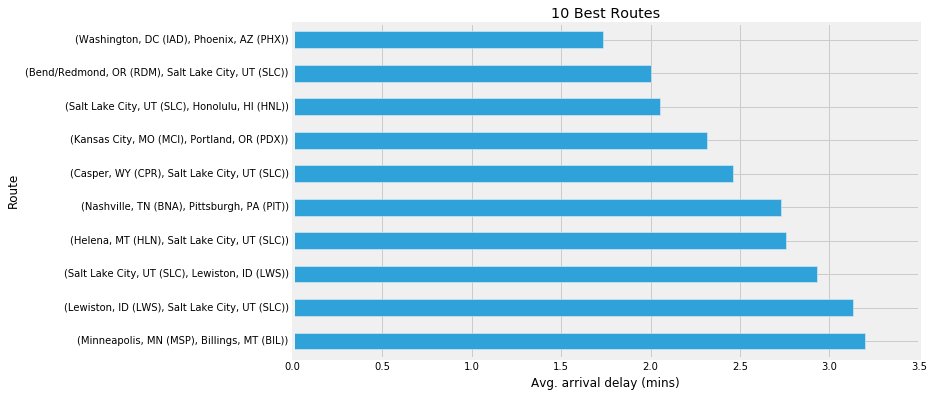

In [55]:
RA = complete2015Data[['UNIQUE_CARRIER', 'DEST', 'ORIGIN', 'ARR_DELAY', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME']]
RA = RA[RA.ARR_DELAY.notnull()] # Ignore entries with NaN values
RA.ix[(RA.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures
RA['ORIGIN'] = RA['ORIGIN_CITY_NAME'] + ' (' + RA['ORIGIN'] + ')'
RA['DEST'] = RA['DEST_CITY_NAME'] + ' (' + RA['DEST'] + ')'

RAgb = RA.groupby(['DEST', 'ORIGIN']).agg({'ARR_DELAY':['mean','count']})
RAgb = RAgb[RAgb['ARR_DELAY']['count'] > threshold] # Select only routes with a certain number of flights
RAgb = RAgb.sort([('ARR_DELAY','mean')], ascending = True)

ax2 = RAgb.head(10)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh') # Create the plot
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Route')
ax2.set_title('10 Best Routes')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


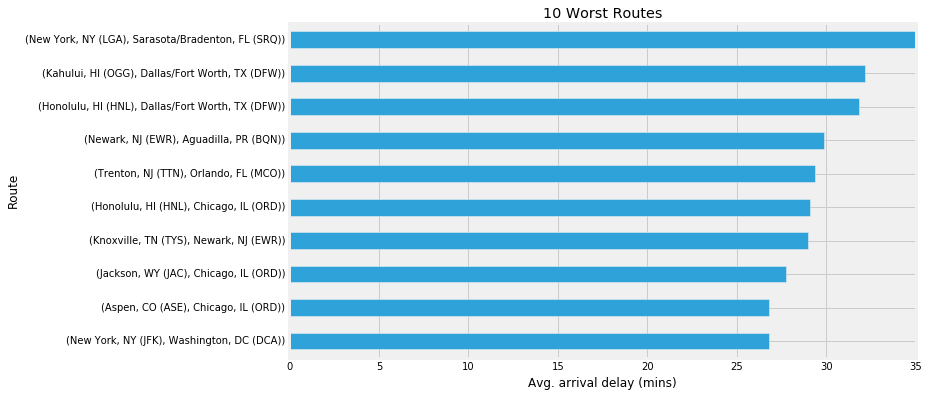

In [56]:
RAgb = RAgb.sort([('ARR_DELAY','mean')], ascending = False)

ax2 = RAgb.head(10)['ARR_DELAY']['mean'].iloc[::-1].plot(kind='barh')
ax2.set_xlabel('Avg. arrival delay (mins)')
ax2.set_ylabel('Route')
ax2.set_title('10 Worst Routes')

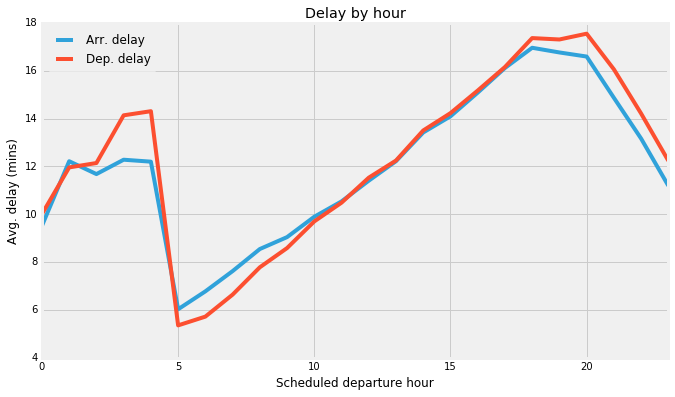

In [57]:
TA = complete2015Data[['CRS_DEP_TIME', 'ARR_DELAY', 'DEP_DELAY']]
TA = TA[TA.ARR_DELAY.notnull() & TA.DEP_DELAY.notnull()] # Ignore entries with NaN values
TA.ix[(TA.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures
TA.ix[(TA.DEP_DELAY < 0), 'DEP_DELAY'] = 0
TA.ix[:, 'CRS_DEP_HOUR'] = (TA['CRS_DEP_TIME'].astype(int) / 100).astype(int)

TAgb = TA.groupby('CRS_DEP_HOUR').agg({'ARR_DELAY':['mean','count'], 'DEP_DELAY':['mean','count']})
TAgb = TAgb[(TAgb[('ARR_DELAY', 'count')] > threshold) & (TAgb[('DEP_DELAY', 'count')] > threshold)]
ax = TAgb.reset_index().plot(kind='line', x='CRS_DEP_HOUR', y=('ARR_DELAY', 'mean'), label='Arr. delay')
ax = TAgb.reset_index().plot(kind='line', x='CRS_DEP_HOUR', y=('DEP_DELAY', 'mean'), label='Dep. delay', ax=ax)

ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Avg. delay (mins)')
ax.set_title('Delay by hour')

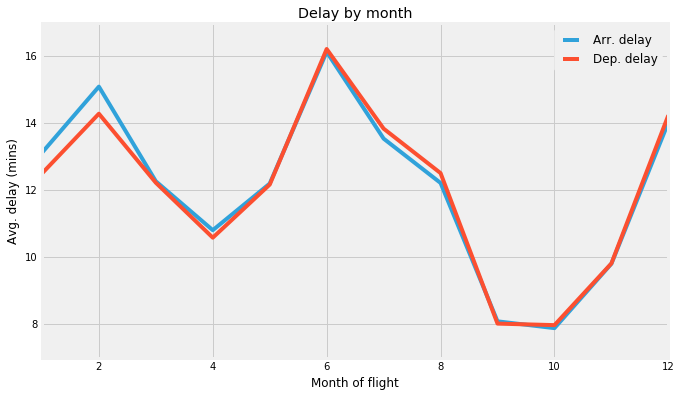

In [58]:
from datetime import datetime

def getMonth(datestring):
    dt = datetime.strptime(datestring, '%Y-%m-%d')
    return dt.month

MD = complete2015Data[['FL_DATE', 'ARR_DELAY', 'DEP_DELAY']]
MD = MD[MD.ARR_DELAY.notnull() & MD.DEP_DELAY.notnull()] # Ignore entries with NaN values
MD.ix[(MD.ARR_DELAY < 0), 'ARR_DELAY'] = 0 # Don't consider early departures
MD.ix[(MD.DEP_DELAY < 0), 'DEP_DELAY'] = 0
MD.ix[:, 'MONTH'] = MD['FL_DATE'].apply(getMonth)

MDgb = MD.groupby('MONTH').agg({'ARR_DELAY':['mean','count'], 'DEP_DELAY':['mean','count']})
MDgb = MDgb[(MDgb[('ARR_DELAY', 'count')] > threshold) & (MDgb[('DEP_DELAY', 'count')] > threshold)]
ax = MDgb.reset_index().plot(kind='line', x='MONTH', y=('ARR_DELAY', 'mean'), label='Arr. delay')
ax = MDgb.reset_index().plot(kind='line', x='MONTH', y=('DEP_DELAY', 'mean'), label='Dep. delay', ax=ax)

ax.set_xlabel('Month of flight')
ax.set_ylabel('Avg. delay (mins)')
ax.set_title('Delay by month')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


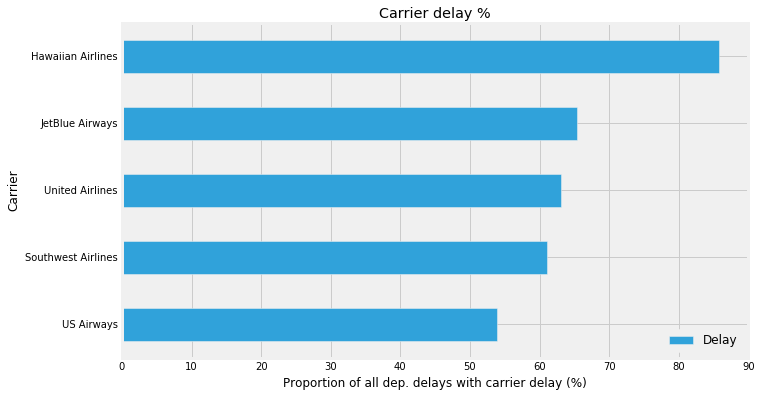

In [59]:
SD = complete2015Data[['UNIQUE_CARRIER', 'CARRIER_DELAY']]
SD = SD[SD.CARRIER_DELAY.notnull()]
SD['AT_FAULT'] = (SD.CARRIER_DELAY > 0) * 100
SD = pd.merge(SD, ANames, how='left', on='UNIQUE_CARRIER')

SD = SD.groupby('UNIQUE_CARRIER').agg( {'AT_FAULT':['count', 'mean'], 'CARRIER_NAME':'min'} )
SD = SD[ (SD['AT_FAULT']['count'] > 0) ] # Make sure flights are above threshold
SD = SD.sort(columns=('AT_FAULT', 'mean'), ascending=False)

ax = SD.head(5).reset_index().iloc[::-1].plot(y=('AT_FAULT', 'mean'), x=('CARRIER_NAME', 'min'), kind='barh', label='Delay')
ax.set_xlabel('Proportion of all dep. delays with carrier delay (%)')
ax.set_ylabel('Carrier')
ax.set_title('Carrier delay %')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


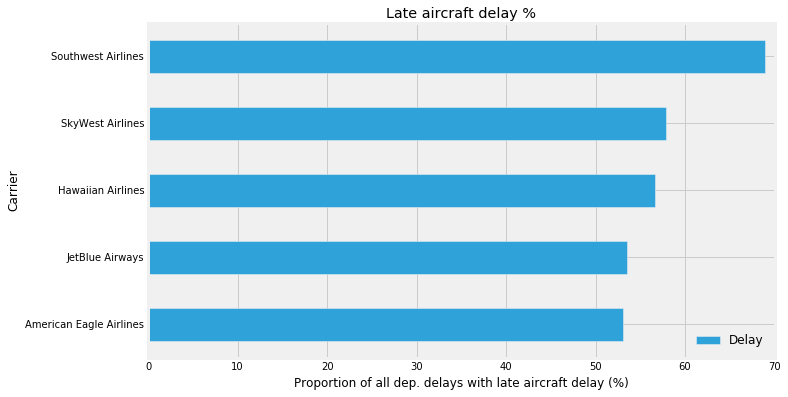

In [60]:
SD = complete2015Data[['UNIQUE_CARRIER', 'LATE_AIRCRAFT_DELAY']]
SD = SD[SD.LATE_AIRCRAFT_DELAY.notnull()]
SD['AT_FAULT'] = (SD.LATE_AIRCRAFT_DELAY > 0) * 100
SD = pd.merge(SD, ANames, how='left', on='UNIQUE_CARRIER')

SD = SD.groupby('UNIQUE_CARRIER').agg( {'AT_FAULT':['count', 'mean'], 'CARRIER_NAME':'min'} )
SD = SD[ (SD['AT_FAULT']['count'] > 0) ] # Make sure flights are above threshold

SD = SD.sort(columns=('AT_FAULT', 'mean'), ascending=False)

ax = SD.head(5).reset_index().iloc[::-1].plot(y=('AT_FAULT', 'mean'), x=('CARRIER_NAME', 'min'), kind='barh', label='Delay')
ax.set_xlabel('Proportion of all dep. delays with late aircraft delay (%)')
ax.set_ylabel('Carrier')
ax.set_title('Late aircraft delay %')

/Applications/Anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


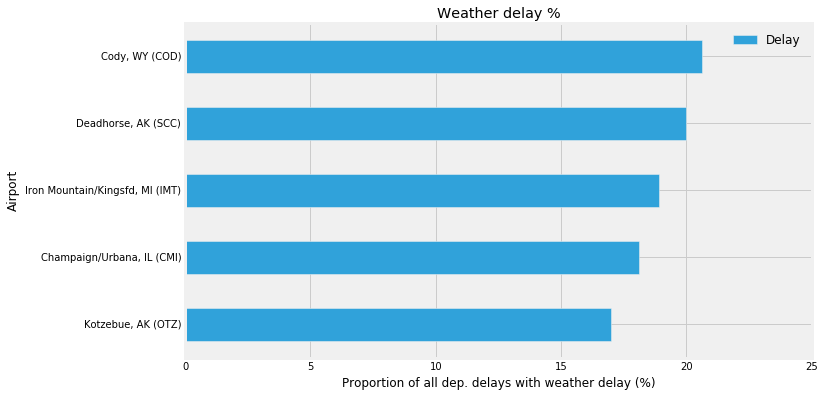

In [61]:
SD = complete2015Data[['ORIGIN', 'ORIGIN_CITY_NAME', 'WEATHER_DELAY']]
SD = SD[SD.WEATHER_DELAY.notnull()]
SD['AT_FAULT'] = (SD.WEATHER_DELAY > 0) * 100
SD['ORIGIN_CITY_NAME'] = SD['ORIGIN_CITY_NAME'] + ' (' + SD['ORIGIN'] + ')'

SD = SD.groupby('ORIGIN').agg( {'AT_FAULT':['count', 'mean'], 'ORIGIN_CITY_NAME':'min'} )
SD = SD[ (SD['AT_FAULT']['count'] > 0) ] # Make sure flights are above threshold
SD = SD.sort(columns=('AT_FAULT', 'mean'), ascending=False)

ax = SD.head(5).reset_index().iloc[::-1].plot(y=('AT_FAULT', 'mean'), x=('ORIGIN_CITY_NAME', 'min'), kind='barh', label='Delay')
ax.set_xlabel('Proportion of all dep. delays with weather delay (%)')
ax.set_ylabel('Airport')
ax.set_title('Weather delay %')

In [68]:
complete2015Data = []